<a href="https://colab.research.google.com/github/sachsac/teaching_data/blob/main/TA_Hours_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install openpyxl==3.0.0

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Work/Independent Projects/TA work/TA helping.xlsx')
df.drop(columns='Student', inplace = True) #dropping for anonymity
df.head()

,Cohort,Stack,Time,Date,Day of week,Time in Military,Off Hours Request? Y/N
0,8/30,Advanced Machine Learning,18:00:00,2021-11-10,Wed,1800,No
1,10/11,Machine Learning,19:36:00,2021-11-10,Wed,1936,No
2,8/30,Advanced Machine Learning,14:05:00,2021-11-11,Thu,1405,Yes
3,8/30,Advanced Machine Learning,22:40:00,2021-11-14,Sun,2240,Yes
4,8/30,Advanced Machine Learning,20:11:00,2021-11-14,Sun,2011,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cohort                  79 non-null     object        
 1   Stack                   79 non-null     object        
 2   Time                    79 non-null     object        
 3   Date                    79 non-null     datetime64[ns]
 4   Day of week             79 non-null     object        
 5   Time in Military        79 non-null     int64         
 6   Off Hours Request? Y/N  79 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.4+ KB


# Can we predict if a student will contact after hours vs during hours?
(A Classification Problem)
Although the Regression Problem was unable to be tackled using this data, can it more reliably help with a classification question?

In [5]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [6]:
#although it is the same data set, we need to redo our train test split and preprocessing steps
X = df.drop(columns =['Off Hours Request? Y/N', 'Time in Military']) #Time in Military mostly used for analysis purposes
y = df['Off Hours Request? Y/N']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [8]:
#code to check the split of our variables
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))

Counts of each class in Training: {'No': 29, 'Yes': 30}
Counts of each class in Test: {'No': 10, 'Yes': 10}


In [9]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [10]:
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [11]:
col_trans = make_column_transformer(num_tuple, cat_tuple)
col_trans.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f65b97db6d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f65b97dbb50>)])

In [12]:
X_train = col_trans.transform(X_train)
X_test = col_trans.transform(X_test)

In [13]:
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True))
print()
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True))  

Baseline Training Accuracy:
Yes    0.508475
No     0.491525
Name: Off Hours Request? Y/N, dtype: float64

Baseline Testing Accuracy:
Yes    0.5
No     0.5
Name: Off Hours Request? Y/N, dtype: float64


In [20]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic Regression Train Performance')
print(metrics.classification_report(y_train, lr.predict(X_train)))
print('Logistic Regression Test Performance')
print(metrics.classification_report(y_test, y_pred))

print()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)
print('KNN Train Performance')
print(metrics.classification_report(y_train, knn.predict(X_train)))
print('KNN Test Performance')
print(metrics.classification_report(y_test, y_pred2))

print()

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)
print('XGB Train Performance')
print(metrics.classification_report(y_train,xgb.predict(X_train)))
print('XGB Test Performance')
print(metrics.classification_report(y_test, y_pred3))

Logistic Regression Train Performance
              precision    recall  f1-score   support

          No       0.97      1.00      0.98        29
         Yes       1.00      0.97      0.98        30

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59

Logistic Regression Test Performance
              precision    recall  f1-score   support

          No       1.00      0.90      0.95        10
         Yes       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


KNN Train Performance
              precision    recall  f1-score   support

          No       0.72      0.90      0.80        29
         Yes       0.87      0.67      0.75        30

    accuracy                           0.78        59
   macro avg       0.80      0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


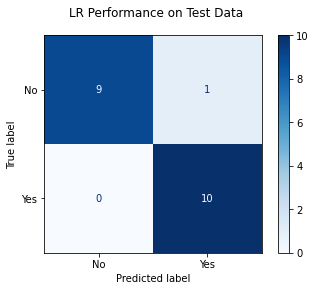

In [16]:
plot_confusion_matrix(lr, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.suptitle('LR Performance on Test Data');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


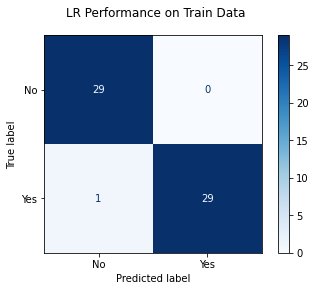

In [17]:
plot_confusion_matrix(lr, X_train, y_train, cmap = 'Blues', values_format = 'd')
plt.suptitle('LR Performance on Train Data');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


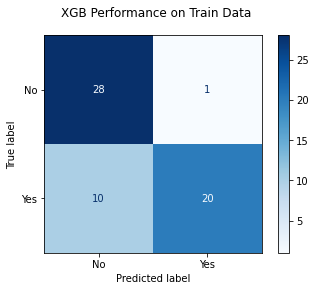

In [19]:
plot_confusion_matrix(xgb, X_train, y_train, cmap = 'Blues', values_format = 'd')
plt.suptitle('XGB Performance on Train Data');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


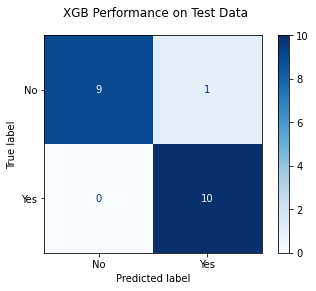

In [18]:
plot_confusion_matrix(xgb, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.suptitle('XGB Performance on Test Data');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is